In [1]:
from fastai.vision.all import *
from duckduckgo_search import ddg_images
from fastcore.all import *

In [2]:
from fastdownload import download_url
from time import sleep

Steps:

1. Create a dataset by downloading images from the internet
2. Verify Images are not corrupted
3. Create model
4. Fine tune model

#### Choose the categories you want to classify

In [1]:
from pathlib import Path


search_terms = ["Bald uakari monkey", "Mandrill monkey", 
                "Panamanian White-faced Capuchin monkey",
                "Golden snub-nosed monkey", 
                "Black howler monkey", "Guinea baboon", 
                "Bonnet macaque", "Japanese macaque"]

output_dir = Path("data")

#### 1. Create a dataset by downloading images from the internet

In [5]:
for term in search_terms:
    # Create folder for search term
    dest = (output_dir/term)
    dest.mkdir(exist_ok=True, parents=True)
    
    # Searchs for images and gets urls
    urls = L(ddg_images(term, max_results=max_images)).itemgot("image")
    
    # Trys downloading images from url
    for url in urls:
        try:
            download_url(url, dest, show_progress=False)
        except:
            continue
    
    # Resizes images
    resize_images(dest, max_size=400, dest=dest)

#### 2. Verify Images are not corrupted

In [6]:
failed = verify_images(get_image_files(output_dir))
failed.map(Path.unlink)
len(failed)

3

#### 3. Create model

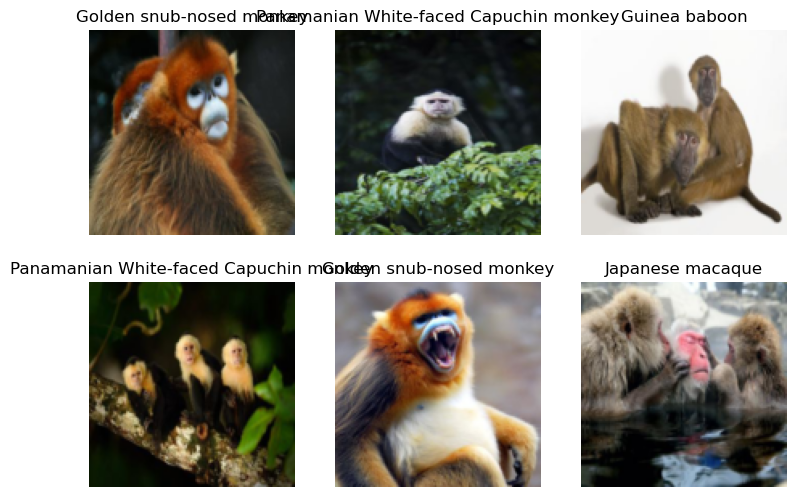

In [7]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label,
    item_tfms=[Resize(128, method="squish")],
).dataloaders(output_dir, bs=32)

dls.show_batch(max_n=6)

#### 4. Fine tune model

In [10]:
learn = vision_learner(dls, resnet18, metrics=[accuracy, error_rate])
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.303896,2.551907,0.404255,0.595745,00:01


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.858827,1.364505,0.638298,0.361702,00:01
1,1.279161,0.840205,0.659574,0.340426,00:01
2,0.950820,0.659005,0.723404,0.276596,00:01
3,0.729181,0.661171,0.744681,0.255319,00:01


To get a better understanding of where the model misclassified and how we can see what the model classified with a confusion matrix and by seeing which item the model was most confused about.

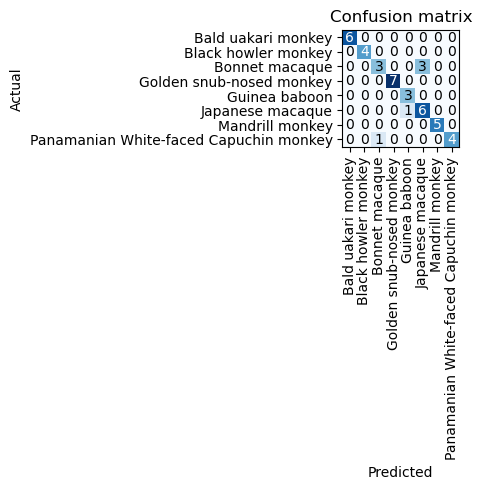

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

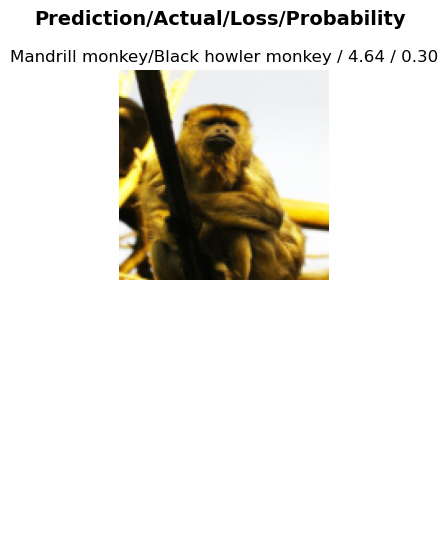

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(1, nrows=2)

Since we created our own dataset we may have pictures that doesn't fit the category so we can use the Image cleaner tool to remove those images from the dataset

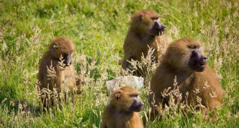

In [19]:
from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(learn)
cleaner

In [21]:
for i in cleaner.delete(): cleaner.fns[i].unlink()
for i, category in cleaner.change():  shutil.move(str(cleaner.fns[i]), path/category)

Let's export the model so we can now deploy it

In [20]:
learn.export("model.pkl")